In [16]:
import os
import requests
import datetime
import calendar
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'font.size': 14})
from sklearn.metrics import mean_squared_error
from matplotlib.offsetbox import AnchoredText

In [2]:
path = Path(r'../data/tides/NOAAtidePredictions/')
stations = {'duck':8651370,
            'oregon': 8652587,
            'hatteras': 8654467,
            'beaufort':8656483,
            'wrightsville': 8658163,
            'wilmington': 8658120}

#### Download data

In [6]:
years = np.arange(2022, 1990, -1)

for st in stations.keys():
    try:
        os.mkdir(path/st)
    except:
        pass
    
    for yy in years:
        #url = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&begin_date={yy}0101&end_date={yy}1231&datum=MSL&station={stations[st]}&time_zone=GMT&units=metric&format=csv'
        url = f'https://tidesandcurrents.noaa.gov/api/datagetter?product=predictions&application=NOS.COOPS.TAC.WL&begin_date={yy}0101&end_date={yy}1231&datum=MSL&station={stations[st]}&time_zone=GMT&units=metric&format=csv'
        r = requests.get(url)
        with open(os.path.join(path, st, f'{st}_{yy-1}to{yy}.csv'),'wb') as f:
            f.write(r.content)

#### Select representative 2-month period

In [3]:
dct = {}
for st in stations.keys():
# st = 'oregon'
    listAux = []
    files = sorted(os.listdir(path/st))
    for f in files:
        df = pd.read_csv(path/st/f, index_col = 0, parse_dates=True)
        listAux.append(df)
    dfAll = pd.concat(listAux)
    # dfAll = dfAll.dropna(axis=0, subset=[' Water Level'])
    dfAll = dfAll.dropna(axis=0, subset=[' Prediction'])
    dfAll.index = pd.to_datetime(dfAll.index)
    dfAll = dfAll.sort_index()
    ## select only months of hurricane seasson
    dct[st] = dfAll[(dfAll.index.month >= 6) & (dfAll.index.month < 12)]

<AxesSubplot: xlabel='Date Time'>

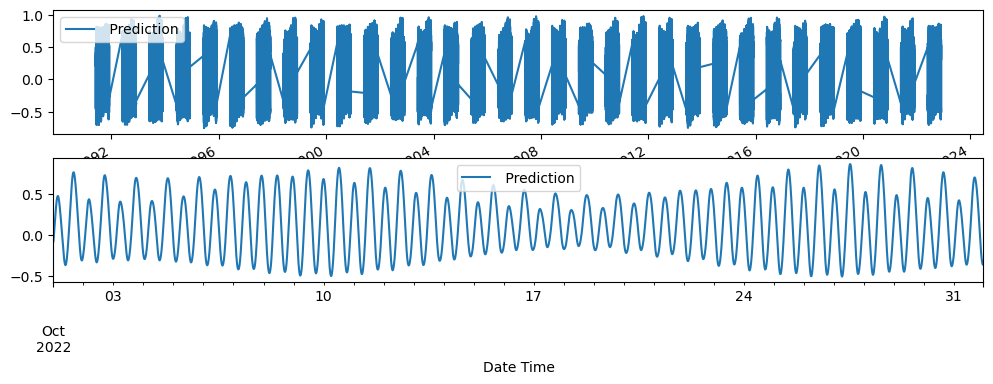

In [11]:
fig, ax = plt.subplots(figsize = (12, 4), nrows = 2)
dct['duck'].plot(ax = ax[0])
aaaa = dct['duck']
aaaa[(aaaa.index.year == 2022) & (aaaa.index.month == 10)].plot(ax = ax[1])

In [4]:
dfQ = []
qs = np.arange(0, 1.01, 0.01)
for key in dct.keys():
    keyQ = []
    for q in qs:
        # keyQ.append(dct[key][' Water Level'].quantile(q))
        keyQ.append(dct[key][' Prediction'].quantile(q))
    dfQ.append(keyQ)
dfQ = pd.DataFrame(np.transpose(dfQ), columns = dct.keys())

In [5]:
dctQ = {}
for key in dct.keys():
    df = dct[key]
    df.index = pd.to_datetime(df.index)
    years = sorted(df.index.year.unique())
    months = sorted(df.index.month.unique())

    dfStQ = []
    cols = []
    for yy in years:
        for mm in np.arange(6, 11, 1): ## only hurricane season
            dfs = df[(df.index.year == yy) & (df.index.month >= mm) & (df.index.month <= mm+1)]
            cols.append(f'{yy}_{mm:02d}to{mm+1:02d}')
            stQ = []
            for q in qs:
                # stQ.append(dfs[' Water Level'].quantile(q))
                stQ.append(dfs[' Prediction'].quantile(q))
            dfStQ.append(stQ)
    dfStQ = pd.DataFrame(np.transpose(dfStQ), columns = cols)
    dctQ[key] = dfStQ

In [6]:
dfRMSE = {}
for key in dct.keys():
    rmse = []
    df = dctQ[key]
    for col in df.columns:
        try:
            rmse.append(np.sqrt(mean_squared_error(dfQ[key], df[col])))
        except:
            rmse.append(np.nan)
    dfRMSE[key] = pd.DataFrame(index = df.columns, data = rmse, columns = [key])

In [7]:
dfRMSE['duck'].head()

,duck
1991_06to07,0.070837
1991_07to08,0.033543
1991_08to09,0.038637
1991_09to10,0.069638
1991_10to11,0.041733


In [8]:
dfQ.head()

,duck,oregon,hatteras,beaufort,wrightsville,wilmington
0,-0.757,-0.165,-0.153,-0.716,-0.895,-0.921
1,-0.604,-0.124,-0.112,-0.567,-0.740,-0.803
2,-0.564,-0.114,-0.100,-0.529,-0.695,-0.768
3,-0.534,-0.107,-0.093,-0.503,-0.661,-0.742
4,-0.510,-0.101,-0.088,-0.482,-0.634,-0.722


In [9]:
indInter = dfRMSE['duck'].index.intersection(dfRMSE['oregon'].index).intersection(dfRMSE['hatteras'].index).intersection(dfRMSE['beaufort'].index).intersection(dfRMSE['wrightsville'].index).intersection(dfRMSE['wilmington'].index)

In [10]:
dfRMSEinter = []
for key in dfRMSE.keys():
    dummy = dfRMSE[key].loc[indInter, :]
    dfRMSEinter.append(dummy)
dfRMSEinter = pd.concat(dfRMSEinter, axis = 1)

In [11]:
meanRMSE = dfRMSEinter.mean(axis = 1)
periodToModel = meanRMSE.idxmin()
periodToModel

'2001_07to08'

In [12]:
meanRMSE.loc[periodToModel]

0.022830491981147363

In [11]:
calendar.monthrange(2001, 7)

(6, 31)

In [12]:
calendar.monthrange(2001, 8)

(2, 31)

In [13]:
datetime.datetime(2001, 6, 16) + datetime.timedelta(days = 77)

datetime.datetime(2001, 9, 1, 0, 0)

In [14]:
dfQ

,duck,oregon,hatteras,beaufort,wrightsville,wilmington
0,-0.757,-0.165,-0.153,-0.716,-0.895,-0.921
1,-0.604,-0.124,-0.112,-0.567,-0.740,-0.803
2,-0.564,-0.114,-0.100,-0.529,-0.695,-0.768
3,-0.534,-0.107,-0.093,-0.503,-0.661,-0.742
4,-0.510,-0.101,-0.088,-0.482,-0.634,-0.722
...,...,...,...,...,...,...
96,0.655,0.222,0.090,0.626,0.807,0.699
97,0.682,0.231,0.096,0.650,0.840,0.722
98,0.718,0.243,0.104,0.681,0.883,0.752
99,0.771,0.259,0.114,0.727,0.944,0.796


Text(0.5, 0.01, 'Percentile')

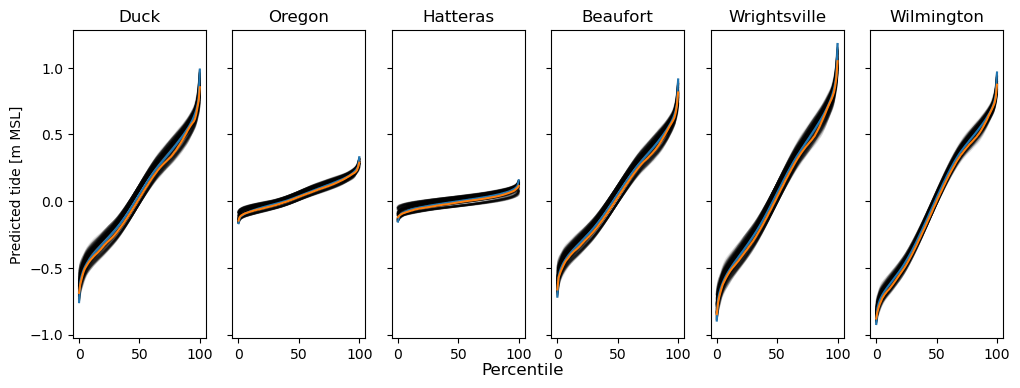

In [15]:
fig, ax = plt.subplots(figsize = (12, 4), ncols = 6, nrows = 1, sharex = True, sharey = True)
for ik, k in enumerate(dctQ.keys()):
    df = dctQ[k]
    axi = ax.flatten()[ik]
    df.plot(ax = axi, color = 'k', alpha = 0.1, legend = False)
    dfQ[k].plot(ax = axi)
    df[periodToModel].plot(ax = axi)
    axi.set_title(k.capitalize())
ax[0].set_ylabel('Predicted tide [m MSL]')
# ax[1, 0].set_ylabel('Predicted tide [m MSL]')
# ax[1, 0].set_xlabel('Percentile')
# ax[1, 1].set_xlabel('Percentile')
# ax[1, 2].set_xlabel('Percentile')
fig.supxlabel('Percentile')

In [26]:
ccolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

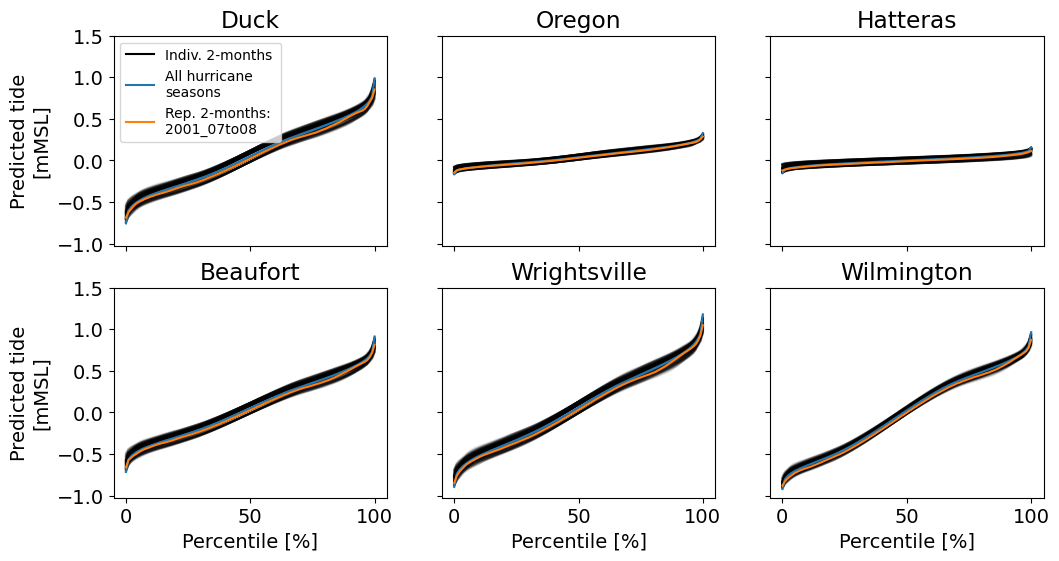

In [20]:
fig, ax = plt.subplots(figsize = (12, 6), ncols = 3, nrows = 2, sharex = True, sharey = True)
for ik, k in enumerate(dctQ.keys()):
    df = dctQ[k]
    axi = ax.flatten()[ik]
    df.plot(ax = axi, color = 'k', alpha = 0.1, legend = False)
    dfQ[k].plot(ax = axi)
    df[periodToModel].plot(ax = axi)
    axi.set_title(k.capitalize())
    axi.set_yticks(np.arange(-1, 2, 0.5))
ax[0, 0].set_ylabel('Predicted tide\n[mMSL]')
ax[1, 0].set_ylabel('Predicted tide\n[mMSL]')
ax[1, 0].set_xlabel('Percentile [%]')
ax[1, 1].set_xlabel('Percentile [%]')
ax[1, 2].set_xlabel('Percentile [%]')

legend_elements = [Line2D([0], [0], color='k', label = 'Indiv. 2-months'), 
                   Line2D([0], [0], color=ccolors[0], label = 'All hurricane\nseasons'),
                   Line2D([0], [0], color=ccolors[1], label = f'Rep. 2-months: \n{periodToModel}')]
ax[0, 0].legend(handles=legend_elements, loc = 'upper left', fontsize = 10)
fig.savefig(r'/mnt/drive1/Insyncs/NCSU/thesis/documents/thesis/2months_periods_tides.png', dpi = 300, bbox_inches = 'tight')

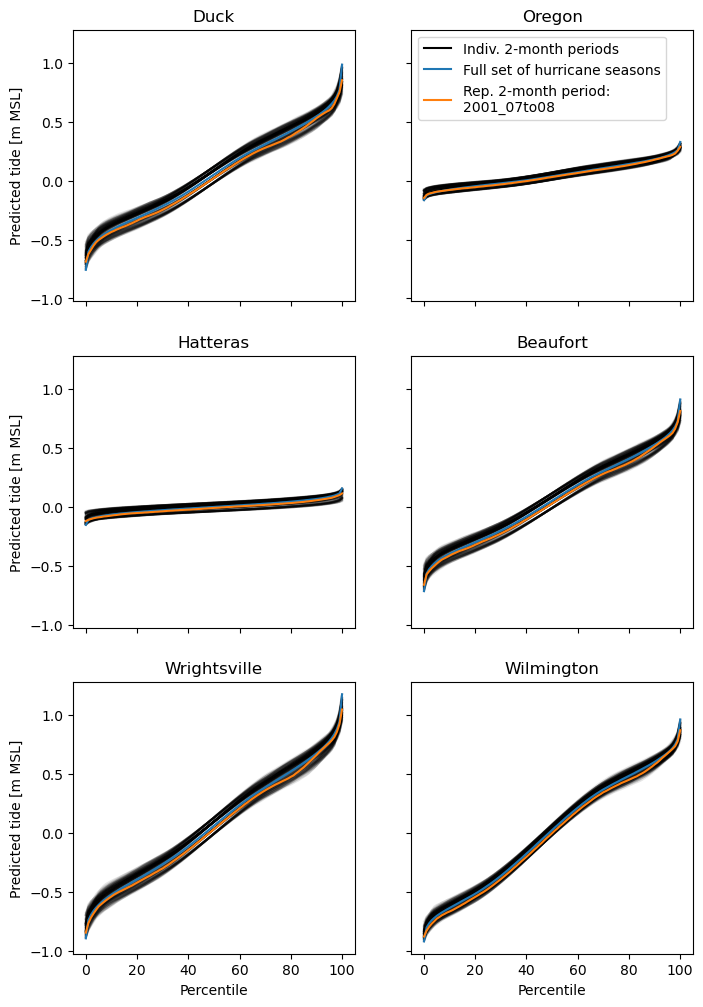

In [32]:
fig, ax = plt.subplots(figsize = (8, 12), ncols = 2, nrows = 3, sharex = True, sharey = True)
for ik, k in enumerate(dctQ.keys()):
    df = dctQ[k]
    axi = ax.flatten()[ik]
    df.plot(ax = axi, color = 'k', alpha = 0.1, legend = False)
    dfQ[k].plot(ax = axi)
    df[periodToModel].plot(ax = axi)
    axi.set_title(k.capitalize())
ax[0, 0].set_ylabel('Predicted tide [m MSL]')
ax[1, 0].set_ylabel('Predicted tide [m MSL]')
ax[2, 0].set_ylabel('Predicted tide [m MSL]')
ax[2, 0].set_xlabel('Percentile')
ax[2, 1].set_xlabel('Percentile')

legend_elements = [Line2D([0], [0], color='k', label = 'Indiv. 2-month periods'), 
                   Line2D([0], [0], color=ccolors[0], label = 'Full set of hurricane seasons'),
                   Line2D([0], [0], color=ccolors[1], label = f'Rep. 2-month period: \n{periodToModel}')]
ax[0, 1].legend(handles=legend_elements, loc = 'upper left')
fig.savefig(r'/mnt/drive1/Insyncs/NCSU/thesis/documents/waves_and_storm_surge/2months_periods_tides.png', dpi = 300, bbox_inches = 'tight')

In [35]:
list(dctQ.keys())

['duck', 'oregon', 'hatteras', 'beaufort', 'wrightsville', 'wilmington']

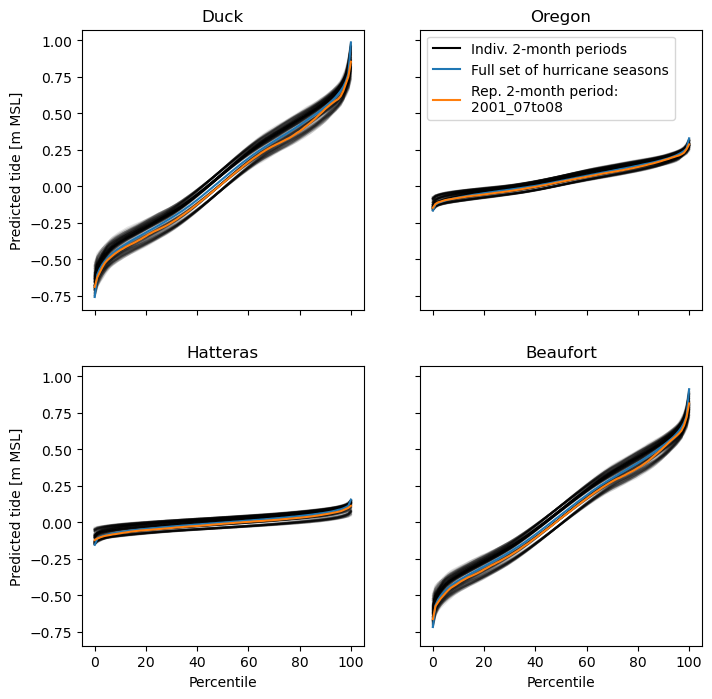

In [38]:
fig, ax = plt.subplots(figsize = (8, 8), ncols = 2, nrows = 2, sharex = True, sharey = True)
for ik, k in enumerate(list(dctQ.keys())[:-2]):
    df = dctQ[k]
    axi = ax.flatten()[ik]
    df.plot(ax = axi, color = 'k', alpha = 0.1, legend = False)
    dfQ[k].plot(ax = axi)
    df[periodToModel].plot(ax = axi)
    axi.set_title(k.capitalize())
ax[0, 0].set_ylabel('Predicted tide [m MSL]')
ax[1, 0].set_ylabel('Predicted tide [m MSL]')
# ax[2, 0].set_ylabel('Predicted tide [m MSL]')
ax[1, 0].set_xlabel('Percentile')
ax[1, 1].set_xlabel('Percentile')

legend_elements = [Line2D([0], [0], color='k', label = 'Indiv. 2-month periods'), 
                   Line2D([0], [0], color=ccolors[0], label = 'Full set of hurricane seasons'),
                   Line2D([0], [0], color=ccolors[1], label = f'Rep. 2-month period: \n{periodToModel}')]
ax[0, 1].legend(handles=legend_elements, loc = 'upper left')
fig.savefig(r'/mnt/drive1/Insyncs/NCSU/thesis/documents/waves_and_storm_surge/2months_periods_tides_2.png', dpi = 300, bbox_inches = 'tight')

Text(-0.19, 0.5, '')

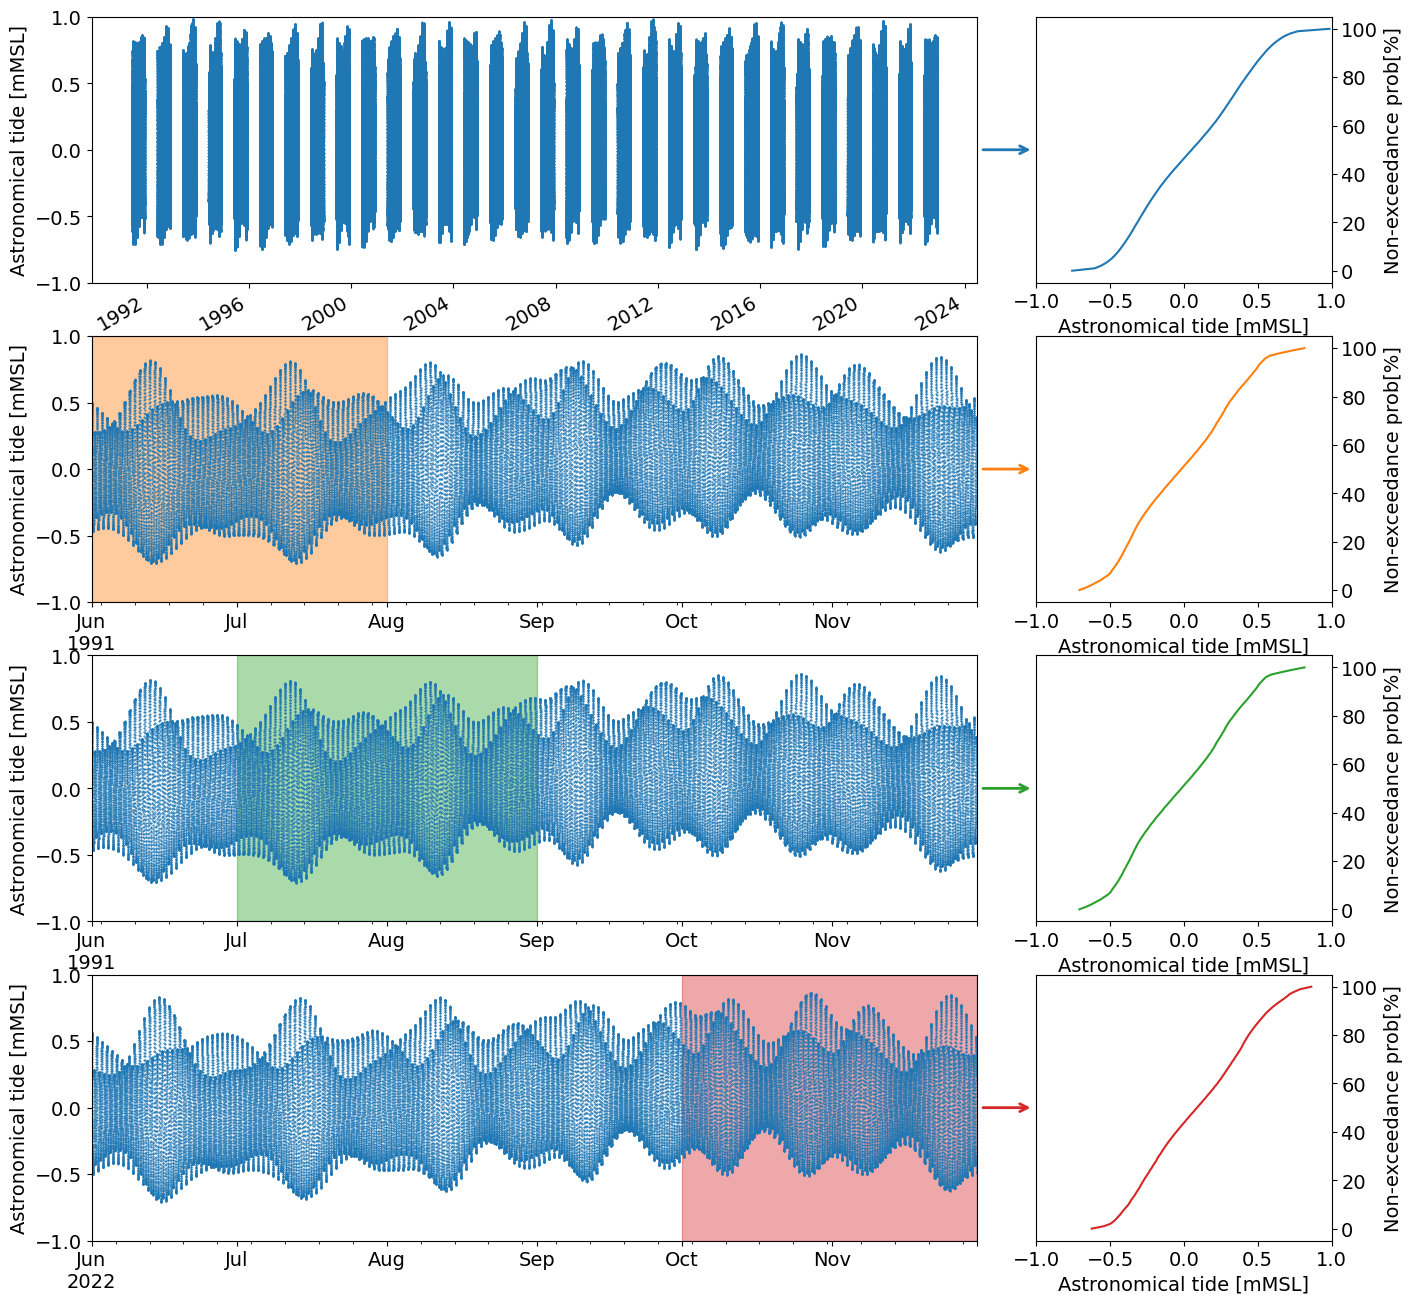

In [14]:
# Calculate arrow coordinates
x_arrow = -0.01  # X-coordinate for the arrow
y_arrow = 0.5    # Y-coordinate for the arrow, between 0 and 1


fig, ax = plt.subplots(figsize = (16, 18), nrows = 4, ncols = 2, gridspec_kw={'width_ratios': [3, 1]})
dct['duck'].plot(ax = ax[0, 0], marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1)
ax[0, 1].plot(dfQ['duck'], dfQ.index)

ax[0, 0].set_ylim([-1, 1])
ax[0, 0].set_xlabel('')
ax[0, 0].set_ylabel('Astronomical tide [mMSL]')

ax[0, 1].yaxis.tick_right()
ax[0, 1].yaxis.set_label_position("right")
ax[0, 1].set_xlabel('Astronomical tide [mMSL]')
ax[0, 1].set_ylabel('Non-exceedance prob[%]')
ax[0, 1].set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[0], edgecolor=ccolors[0], arrowstyle='->', linewidth=2)
ax[0, 1].annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

dct['duck'][dct['duck'].index.year == 1991].plot(ax = ax[1, 0], marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax[1, 0].fill_between(x = pd.date_range('1991-06-01', '1991-08-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[1], alpha = 0.4)
ax[1, 1].plot(dctQ['duck']['1991_06to07'], dfQ.index, color = ccolors[1])

ax[1, 0].set_ylim([-1, 1])
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel('Astronomical tide [mMSL]')

ax[1, 1].yaxis.tick_right()
ax[1, 1].yaxis.set_label_position("right")
ax[1, 1].set_xlabel('Astronomical tide [mMSL]')
ax[1, 1].set_ylabel('Non-exceedance prob[%]')
ax[1, 1].set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[1], edgecolor=ccolors[1], arrowstyle='->', linewidth=2)
ax[1, 1].annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

dct['duck'][dct['duck'].index.year == 1991].plot(ax = ax[2, 0], marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax[2, 0].fill_between(x = pd.date_range('1991-07-01', '1991-09-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[2], alpha = 0.4)
ax[2, 1].plot(dctQ['duck']['1991_06to07'], dfQ.index, color = ccolors[2])

ax[2, 0].set_ylim([-1, 1])
ax[2, 0].set_xlabel('')
ax[2, 0].set_ylabel('Astronomical tide [mMSL]')

ax[2, 1].yaxis.tick_right()
ax[2, 1].yaxis.set_label_position("right")
ax[2, 1].set_xlabel('Astronomical tide [mMSL]')
ax[2, 1].set_ylabel('Non-exceedance prob[%]')
ax[2, 1].set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[2], edgecolor=ccolors[2], arrowstyle='->', linewidth=2)
ax[2, 1].annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

dct['duck'][dct['duck'].index.year == 2022].plot(ax = ax[3, 0], marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax[3, 0].fill_between(x = pd.date_range('2022-10-01', '2022-12-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[3], alpha = 0.4)
ax[3, 1].plot(dctQ['duck']['2022_10to11'], dfQ.index, color = ccolors[3])

ax[3, 0].set_ylim([-1, 1])
ax[3, 0].set_xlabel('')
ax[3, 0].set_ylabel('Astronomical tide [mMSL]')

ax[3, 1].yaxis.tick_right()
ax[3, 1].yaxis.set_label_position("right")
ax[3, 1].set_xlabel('Astronomical tide [mMSL]')
ax[3, 1].set_ylabel('Non-exceedance prob[%]')
ax[3, 1].set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[3], edgecolor=ccolors[3], arrowstyle='->', linewidth=2)
ax[3, 1].annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

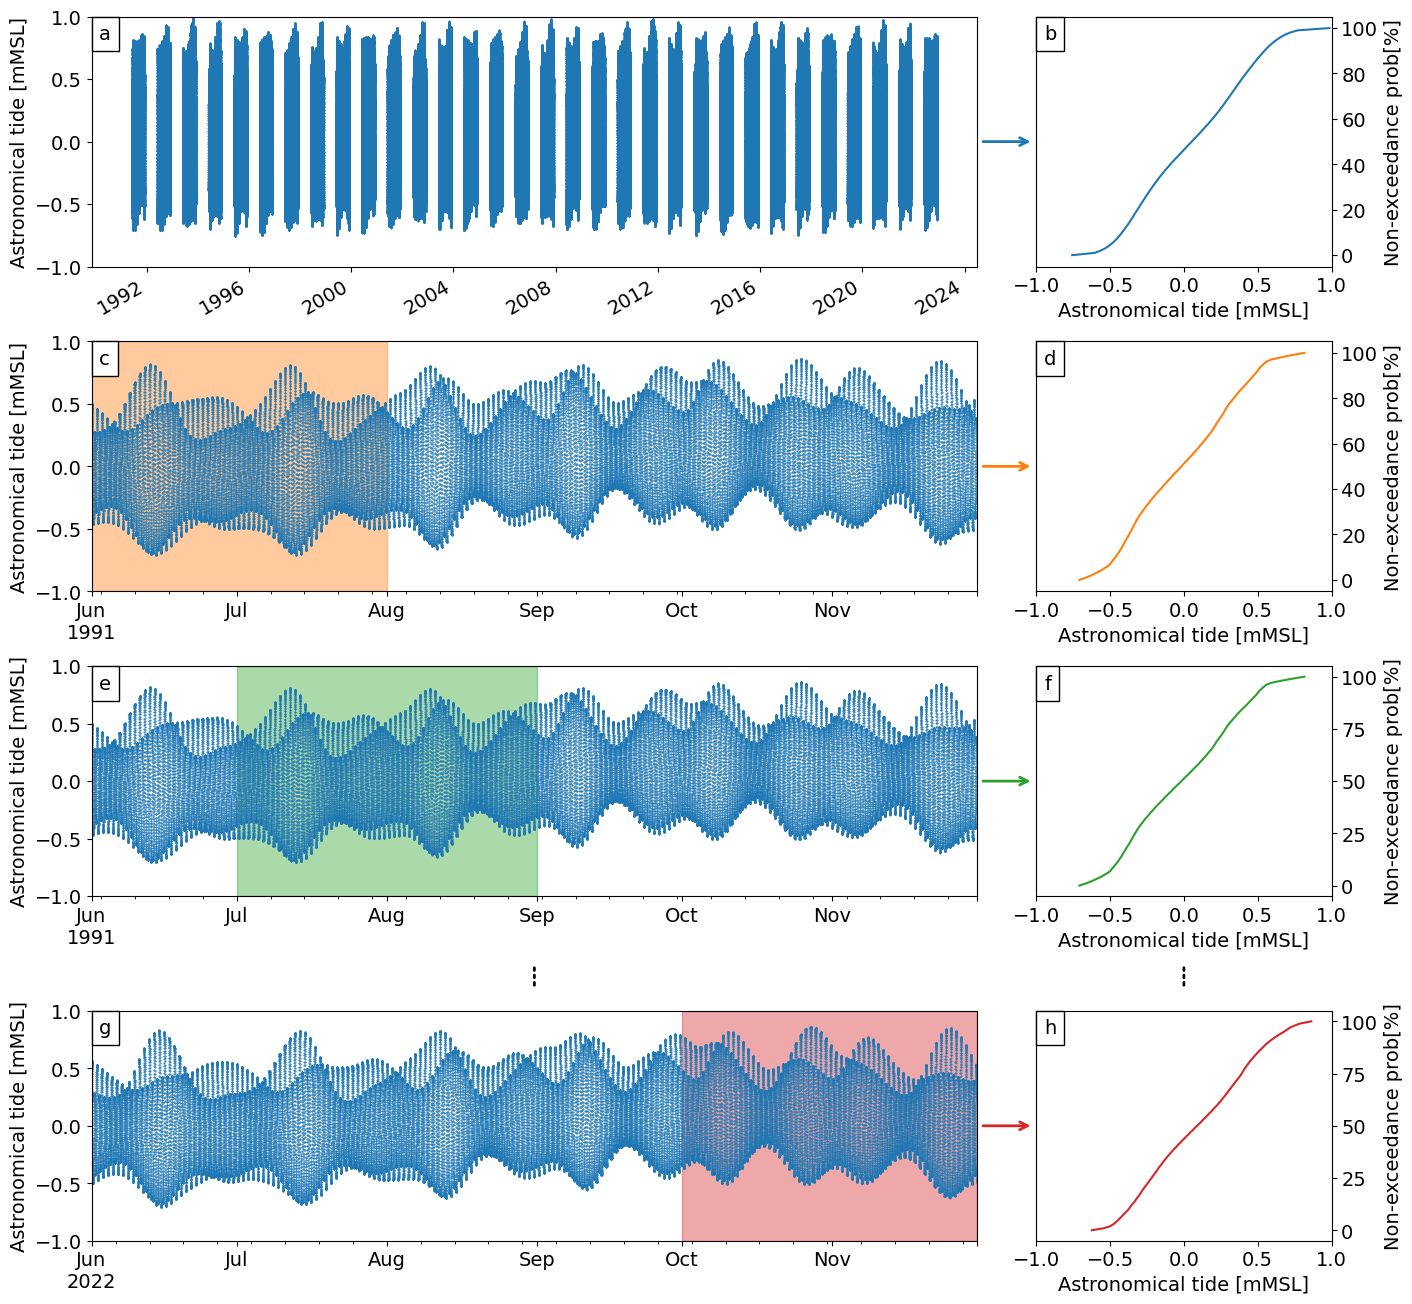

In [22]:
fig = plt.figure(figsize=(16, 18))

outer_grid = fig.add_gridspec(4, 2, width_ratios=[3, 1], hspace=0.3, height_ratios=[1, 1, 1, 1])
ax_0_0 = fig.add_subplot(outer_grid[0, 0])
ax_0_0.add_artist(AnchoredText('a', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_0_1 = fig.add_subplot(outer_grid[0, 1])
ax_0_1.add_artist(AnchoredText('b', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_1_0 = fig.add_subplot(outer_grid[1, 0])
ax_1_0.add_artist(AnchoredText('c', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_1_1 = fig.add_subplot(outer_grid[1, 1])
ax_1_1.add_artist(AnchoredText('d', loc=2,borderpad=0.,frameon=True, alpha = 1))

dct['duck'].plot(ax = ax_0_0, marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1)
ax_0_1.plot(dfQ['duck'], dfQ.index)

ax_0_0.set_ylim([-1, 1])
ax_0_0.set_xlabel('')
ax_0_0.set_ylabel('Astronomical tide [mMSL]')

ax_0_1.yaxis.tick_right()
ax_0_1.yaxis.set_label_position("right")
ax_0_1.set_xlabel('Astronomical tide [mMSL]')
ax_0_1.set_ylabel('Non-exceedance prob[%]')
ax_0_1.set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[0], edgecolor=ccolors[0], arrowstyle='->', linewidth=2)
ax_0_1.annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

dct['duck'][dct['duck'].index.year == 1991].plot(ax = ax_1_0, marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax_1_0.fill_between(x = pd.date_range('1991-06-01', '1991-08-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[1], alpha = 0.4)
ax_1_1.plot(dctQ['duck']['1991_06to07'], dfQ.index, color = ccolors[1])

ax_1_0.set_ylim([-1, 1])
ax_1_0.set_xlabel('')
ax_1_0.set_ylabel('Astronomical tide [mMSL]')

ax_1_1.yaxis.tick_right()
ax_1_1.yaxis.set_label_position("right")
ax_1_1.set_xlabel('Astronomical tide [mMSL]')
ax_1_1.set_ylabel('Non-exceedance prob[%]')
ax_1_1.set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[1], edgecolor=ccolors[1], arrowstyle='->', linewidth=2)
ax_1_1.annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

inner_grid = outer_grid[4:].subgridspec(2, 2, height_ratios=[1, 1], width_ratios=[3, 1], hspace=0.5)

# Plotting in the last two rows
ax_2_0 = fig.add_subplot(inner_grid[0, 0])
ax_2_0.add_artist(AnchoredText('e', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_2_1 = fig.add_subplot(inner_grid[0, 1])
ax_2_1.add_artist(AnchoredText('f', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_3_0 = fig.add_subplot(inner_grid[1, 0])
ax_3_0.add_artist(AnchoredText('g', loc=2,borderpad=0.,frameon=True, alpha = 1))
ax_3_1 = fig.add_subplot(inner_grid[1, 1])
ax_3_1.add_artist(AnchoredText('h', loc=2,borderpad=0.,frameon=True, alpha = 1))

dct['duck'][dct['duck'].index.year == 1991].plot(ax = ax_2_0, marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax_2_0.fill_between(x = pd.date_range('1991-07-01', '1991-09-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[2], alpha = 0.4)
ax_2_1.plot(dctQ['duck']['1991_06to07'], dfQ.index, color = ccolors[2])

ax_2_0.set_ylim([-1, 1])
ax_2_0.set_xlabel('')
ax_2_0.set_ylabel('Astronomical tide [mMSL]')

ax_2_1.yaxis.tick_right()
ax_2_1.yaxis.set_label_position("right")
ax_2_1.set_xlabel('Astronomical tide [mMSL]')
ax_2_1.set_ylabel('Non-exceedance prob[%]')
ax_2_1.set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[2], edgecolor=ccolors[2], arrowstyle='->', linewidth=2)
ax_2_1.annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

dct['duck'][dct['duck'].index.year == 2022].plot(ax = ax_3_0, marker = '.', ls = '', label = '_nolegend_', legend = False, markersize = 1, color = ccolors[0])
ax_3_0.fill_between(x = pd.date_range('2022-10-01', '2022-12-01', freq = '3H'), y1 = -1, y2 = 1, color = ccolors[3], alpha = 0.4)
ax_3_1.plot(dctQ['duck']['2022_10to11'], dfQ.index, color = ccolors[3])

ax_3_0.set_ylim([-1, 1])
ax_3_0.set_xlabel('')
ax_3_0.set_ylabel('Astronomical tide [mMSL]')

ax_3_1.yaxis.tick_right()
ax_3_1.yaxis.set_label_position("right")
ax_3_1.set_xlabel('Astronomical tide [mMSL]')
ax_3_1.set_ylabel('Non-exceedance prob[%]')
ax_3_1.set_xlim([-1, 1])
plt.subplots_adjust(wspace=0.1)
arrow_props = dict(facecolor=ccolors[3], edgecolor=ccolors[3], arrowstyle='->', linewidth=2)
ax_3_1.annotate('', xy=(x_arrow, y_arrow), xytext=(-0.19, y_arrow),
                  arrowprops=arrow_props, xycoords='axes fraction')

ax_3_0.annotate('', xy=(0.5, 1.08), xytext=(0.5, 1.2), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
ax_3_1.annotate('', xy=(0.5, 1.08), xytext=(0.5, 1.2), arrowprops=dict(arrowstyle='-', ls=':', lw=2, color='black'), xycoords='axes fraction')
fig.savefig(r'/mnt/drive1/Insyncs/NCSU/thesis/documents/thesis/2month_tides_selection.png', dpi = 300, bbox_inches = 'tight')